## Foreword

#### Please note we have not carried out any unit/integration tests, therefore in order to avoid any potential code breaks please only change settings/paths where explicitly stated.

#### In order to test the model on subsequent test days, please go to section 3

There are a couple of notebooks which I have not sent over due to the coding being very rough.  I used those notebooks for research purpose, e.g. EDA for missing values/outliers, model diagnosis etc. I have explained the work in this notebook, however i can provide the rough notebooks on request.

In [1]:
import pandas as pd
import numpy as np
import missingno
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from itertools import compress
from tqdm import tqdm
import random
import os
import seaborn as sns
import glob
from sklearn.metrics import accuracy_score
from typing import Dict, List, Tuple
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt import hp
from sklearn.model_selection import TimeSeriesSplit
import json
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

from preprocess import preprocessor
from features import features
from featureSelection import select
from modelOpt import HPOpt

import warnings
warnings.filterwarnings('ignore')

# 1. Overview.


We took a classification approach for this task with a few creative tweaks.  We treated this as a binary problem (1 to buy, 0 to sell).

#### Directory structure.
Below we describe the directory structure to help understand how the module is used.
<img src="img/tree.png">

#### Data Splitting.
We only have 63 days worth of data.  To get a reliable performance of our approach we split the data into two sets, train (60 days) and test (3 days).  The train data is further split into 3 folds, 16 days train, 1 day drop and 3 days validation set. 
1. Set 1: 1-16 = train, 17 drop, 18-20 = validation
2. Set 2: 21-36 = train, 37 drop, 38-40 = validation
3. Set 3: 41-56 = train, 57 drop, 58-60 = validation

We have designed the train/val sets with the intention that they are able to capture different market dynamics to overcome the non-stationary properties of the financial timeseries.

Furthermore, special attention is required to ensure no time leakage is occuring - which we did not encounter in our framework as we validated it with gaussian inputs.

#### Target Design
The target designed here is the forward looking returns.  We aim to predict 1 if the forward looking returns are positive and 0 if negative. We have designed a multi-target approach.  We have 3 targets:
1. "target": 30 minute forward looking returns This is our main target.
2. "target1": 5 minute forward looking returns.
3. "target2": 15 minute forward looking returns.

The logic behind having multiple targets is to increase model's robustness

#### Framework
<img src="img/architecture.png">


The framework we utilise is modularised, enabling transparency, ease of diagnosis and enhancements at granular level. Each level can be interrogated for performance analysis and enhancement, which is vital for a consistent profitable strategy.

The framework we deployed is as follows:
1. Features <b>(features.py)</b>: This is one of the key components for a successful trading strategy.  Features are responsible for alpha discovery and significant time/effort should be spent at this level. Features can be either hypothesis based or data mining approaches, I prefer to use both.  However, we cannot use hypothesis first approach we do not have any meta information regarding the data.  Due to time constraint for this task we have used very simple features (moving averages, covariances etc.).  We also need to pay attention to not use price based features as (as financial timeseries are considered martinagles) and they are not stationary.
2. Feature selection <b>(featureSelection.py)</b>: The feature selection module's function is to select the relevant features to reduce model complexity to avoid overfitting.  This is run only on the ./trainData to identify the best performing features.  Each of our model generated utilises either 5,10 or 15 features, this is to avoid model overfitting.  The feature selection process works as follows, first select 30 features randomly from our feature universe. We then carry out recursive feature elmination (with dependent variable being "target") using a shallow (1 depth) lightgbm classifier. We then extract 5,10,15 top performing features by observing feature_importance. We run several trials to get an average of best performing features.  We repeat this for each combination of the following, fold and feature group (5,10,15). This results in a 3x3=9 selected feature groups, this can be found in <b>.selectedFeatures/</b>.  This is done for each of the 50 stocks.
3. Model <b>(modelOpt.py)</b>.  The models are created using <b>./trainData</b> only and saved in <b>./models</b>. We train lightgbm classifiers, allows us to ignore data standardization. We train the hyper parameters using bayesian optimisation (for speed), more specifically tree of Parzen estimators.  The model training process is as follows, we train a single model for each of the following combinations, fold (3), feature group ([5,10,15], 3) and each target (3).  This results in 27 models for each stock.  In total we have trained 27*50=1350 models.  Due to time limitations we have not fully optimised the hyperparameters.

For each stock, we output 27 probabilities which are then averaged to create a single prediction. There are ofcourse alternatives to averaging, e.g. using elastic net, or even utilising error residuals online to adjust models during trading.

#### Data Cleansing (preprocess.py).
During data cleansing we focused on 2 areas, missing values and outliers, both which were present in our dataset. The full EDA of the data is not provided here as its rough code (can provide at request) but I will discuss my findings.

For missing values we identified that there are some moments where all stocks have every column missing, we assume this is due to trading breaks/halts. In this situation (less than 1% of the time) we drop the rows.
In scenario where only specific stocks are missing information, we forward fill.
See figures below for missing value patterns, these are visible across all stocks

In [2]:
dataPath = './trainData/'
dataObj = preprocessor(dataPath)
dataObj.dataLoader()

<AxesSubplot:>

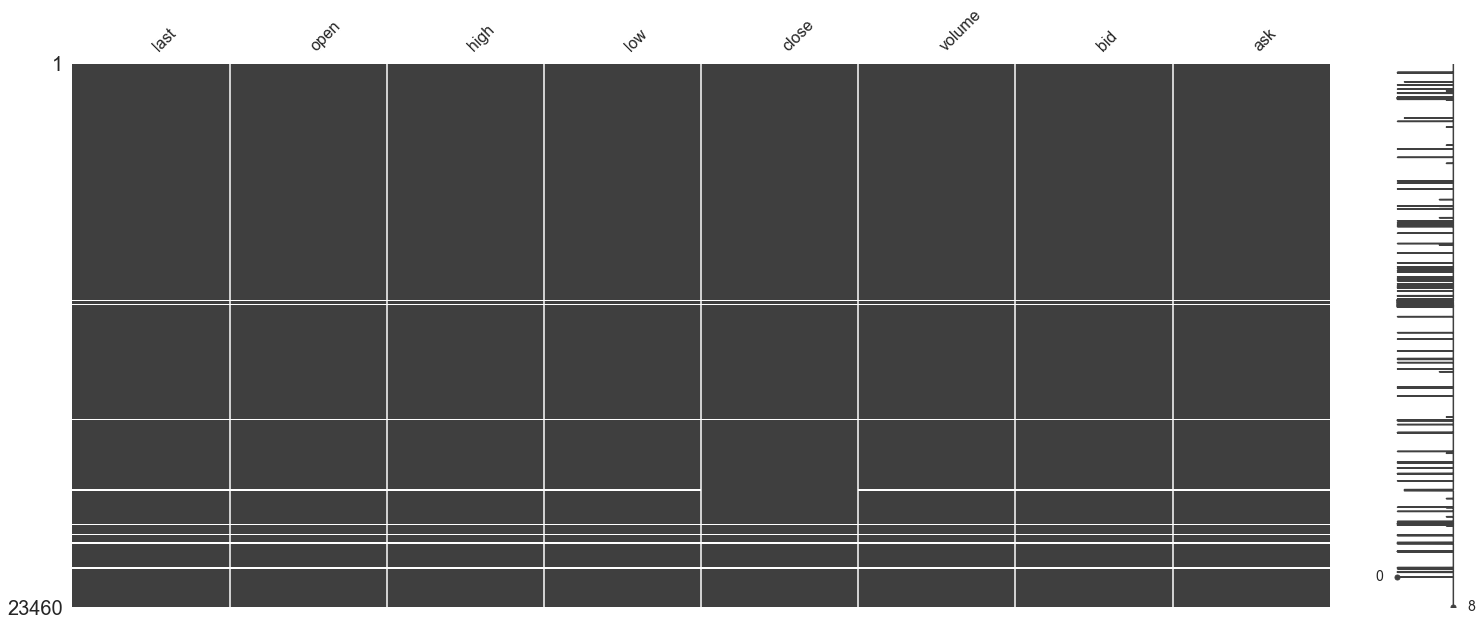

In [3]:
#For stock = 1
missingno.matrix(dataObj.df.xs(1, level=1, axis=1))

<AxesSubplot:>

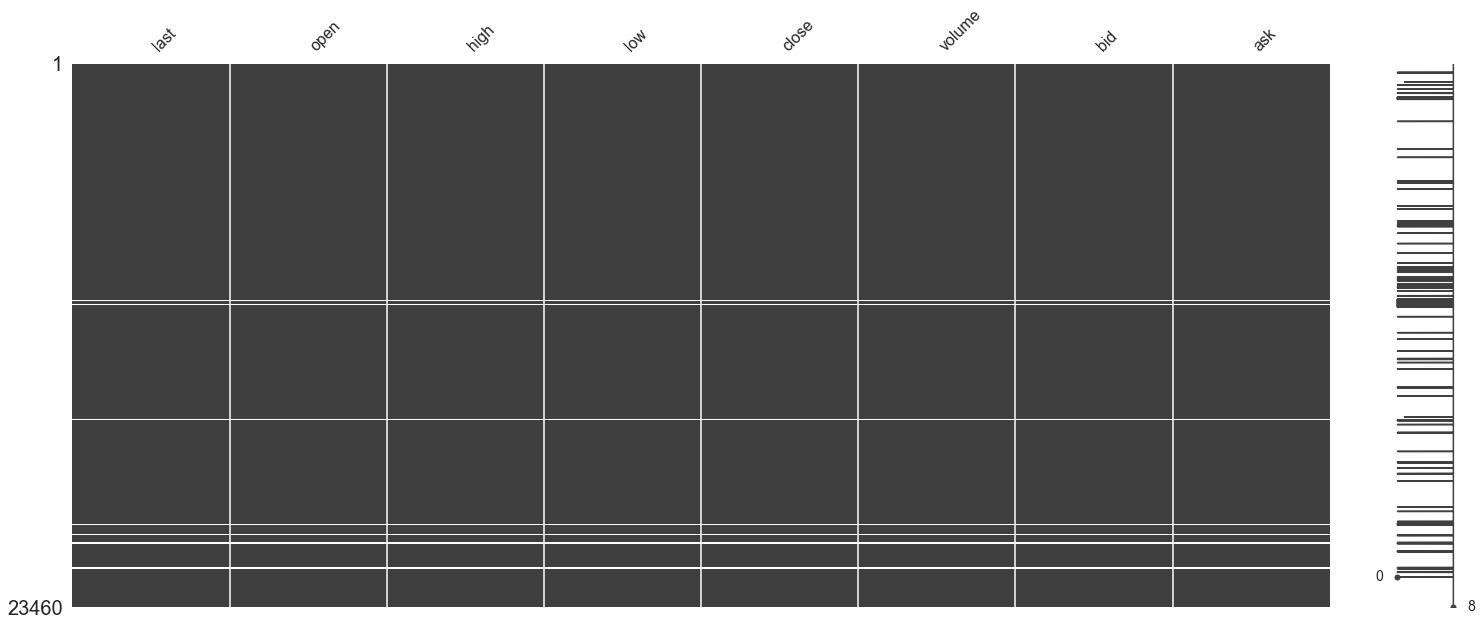

In [4]:
missingno.matrix(dataObj.df.xs(2, level=1, axis=1))

We identified outliers using bid/ask spread - which would have significant impact when calculating PnL.  The logic here was, if the spread at a given time step is greater than 95th percentile of the train dataset then we drop the row. We save these 95th percentile values down during train in <b>./features/{stock}.txt</b> such that they can be used during test period. See below as an example of the spread identifying outliers.

<AxesSubplot:xlabel='date,time', ylabel='spread'>

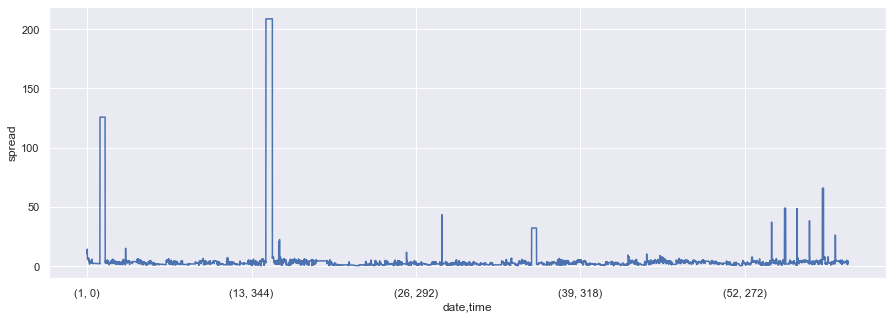

In [5]:
dataPath = './trainData/'
dataObj = preprocessor(dataPath)
dataObj.run()

df = dataObj.df.xs(47, level=1, axis=1)

df['spread'] = df.ask - df.bid

plt.figure(figsize=(15,5))
plt.ylabel('spread')
df.spread.plot()

#### Portfolio formation.
We take a naive 1/N approach to forming our portfolios.  The logic is as follows:
1. For each stock, we get the average prediction from the 27 models.
2. If prediction > 0.75 go long, if prediction < -0.75 then short.
3. Close long when prediction < 0, close short when prediction > 0
4. If none of the above conditions met, then do not trade.

Just to note, this is a very simple approach and implemented due to time constraints, and in practice we ofcourse will take into consideration the covariances in order to make better decisions. 

#### Potential Work.
See bottom of the notebook for potentially interesting stuff to try.

# 2. Train

#### WARNING: The train section can take a couple hours to run (2 hours on 64gb RAM I7 9700k) .

Load the train data (60 days max) and resolve missing data. We remove outliers in next step due to ease.

In [6]:
dataPath = './trainData/'
#Splitting train/val data.  Train+val goes upto 60 days. Days 61/62/63 are kept for our out-of-sample test.
dataObj = preprocessor(dataPath)
dataObj.run()

#Check if any nan, should be 0
print(dataObj.df.isna().sum().max())
print(dataObj.df.shape)

0
(23136, 400)


#### Feature + target  + outlier removal

In [7]:
featuresObj = features(data=dataObj.df, outputPath='./features', trainFlag=True)
featuresObj.run()

Creating global features: Covariances...


100%|██████████| 23087/23087 [00:13<00:00, 1665.19it/s]


Creating global features: Bid ask ratios
Creating features...


100%|██████████| 50/50 [11:57<00:00, 14.35s/it]


#### Feature selection

Each model will have either 5,10 or 15 features at most. This is to minimise overfitting as we have small data (16 days per train session).
Splits are desgined so we capture different market conditions - and therefore the most appropriate features during the period.  This is to increase model robustness and to overcome non-stationarity present in financial timeseries.

In [9]:
splits = [([i for i in range(1,17)], [i for i in range(18,21)]), 
                ([i for i in range(21,37)], [i for i in range(38,41)]), 
                ([i for i in range(41,57)],[i for i in range(58,61)])]
selectObj = select(outputPath='./selectedFeatures',inputPath='./features', splits=splits)
selectObj.run()

100%|██████████| 50/50 [52:46<00:00, 63.34s/it]


#### Model training/optimisation
we create a model for each fold (3), target (3) , feature group (3). That is 27 models per stock, 27*50 = 1350 models for all stocks
To save time we have not fully optimised the hyper parameters.

In [10]:
stockIds = [i for i in range(1,51)]
featureGroups = [5,10,15]
targets = ['target', 'target1', 'target2']
for stock in tqdm(stockIds):
    df = pd.read_csv(f'./features/{stock}.csv')
    for group in featureGroups:
        for target in targets:
            trials = Trials()
            obj = HPOpt(df=df, splits=splits, stock_id=stock, target=target,featureGroup=group)
            obj.process(fn_name='lgb_clf', space=obj.lgb_para, trials=trials, algo=tpe.suggest, max_evals=10)

            models = obj.getBestModelfromTrials(trials)
            path = f'./models/{stock}/'
            if not os.path.isdir(path):
                os.makedirs(path)
            for model in models:
                model['model'].save_model(path+f'{target}_'+model['info']+'.txt', 
                                        num_iteration=model['model'].best_iteration)

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: 0.4324361106417235]

100%|██████████| 10/10 [00:03<00:00,  2.92trial/s, best loss: 0.4022162546257957]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.4646749423247202]

100%|██████████| 10/10 [00:03<00:00,  2.61trial/s, best loss: 0.43361327378902326]

100%|██████████| 10/10 [00:03<00:00,  2.83trial/s, best loss: 0.39193017298002264]

100%|██████████| 10/10 [00:04<00:00,  2.40trial/s, best loss: 0.4625045052196536]

100%|██████████| 10/10 [00:04<00:00,  2.34trial/s, best loss: 0.44084803413924556]

100%|██████████| 10/10 [00:04<00:00,  2.40trial/s, best loss: 0.3984273496269072]

100%|██████████| 10/10 [00:04<00:00,  2.16trial/s, best loss: 0.4445663809550583]

  2%|▏         | 1/50 [00:37<30:28, 37.31s/it]



100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.46052729528079206]

100%|██████████| 10/10 [00:03<00:00,  2.95trial/s, best loss: 0.48313507566449176]

100%|██████████| 10/10 [00:03<00:00,  3.04trial/s, best loss: 0.4794692612727859]

100%|██████████| 10/10 [00:05<00:00,  1.90trial/s, best loss: 0.47496110653750545]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 0.48115897755793113]

100%|██████████| 10/10 [00:04<00:00,  2.24trial/s, best loss: 0.4562343173485638]

100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: 0.4772895658632822]

100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.4806521458072601]

100%|██████████| 10/10 [00:05<00:00,  1.81trial/s, best loss: 0.4585771768219119]

  4%|▍         | 2/50 [01:17<31:00, 38.77s/it]



100%|██████████| 10/10 [00:04<00:00,  2.11trial/s, best loss: 0.3655313096952302]

100%|██████████| 10/10 [00:04<00:00,  2.38trial/s, best loss: 0.18193173362196424]

100%|██████████| 10/10 [00:03<00:00,  2.86trial/s, best loss: 0.3073219169477275]

100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.3486145069274653]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.18193173362196424]

100%|██████████| 10/10 [00:03<00:00,  2.88trial/s, best loss: 0.3096614062384234]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 0.35469959507909976]

100%|██████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: 0.18193173362196424]

100%|██████████| 10/10 [00:04<00:00,  2.36trial/s, best loss: 0.31127448611768793]

  6%|▌         | 3/50 [01:54<29:53, 38.16s/it]



100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.43992523242092596]

100%|██████████| 10/10 [00:03<00:00,  2.87trial/s, best loss: 0.4562140907675528]

100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.4581655141547035]

100%|██████████| 10/10 [00:04<00:00,  2.39trial/s, best loss: 0.4408373518365125]

100%|██████████| 10/10 [00:13<00:00,  1.36s/trial, best loss: 0.43784790178850275]

100%|██████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: 0.4663833007729532]

100%|██████████| 10/10 [00:04<00:00,  2.30trial/s, best loss: 0.43940211319774203]

100%|██████████| 10/10 [00:05<00:00,  1.86trial/s, best loss: 0.4561061910711106]

100%|██████████| 10/10 [00:04<00:00,  2.11trial/s, best loss: 0.45722218995418407]

  8%|▊         | 4/50 [02:44<32:47, 42.77s/it]



100%|██████████| 10/10 [00:03<00:00,  2.99trial/s, best loss: 0.46920234435200137]

100%|██████████| 10/10 [00:05<00:00,  1.78trial/s, best loss: 0.47399205044948556]

100%|██████████| 10/10 [00:04<00:00,  2.06trial/s, best loss: 0.44699060257667034]

100%|██████████| 10/10 [00:05<00:00,  1.68trial/s, best loss: 0.44177885734801114]

100%|██████████| 10/10 [00:07<00:00,  1.29trial/s, best loss: 0.4567563800914972]

100%|██████████| 10/10 [00:06<00:00,  1.63trial/s, best loss: 0.45735865493964467]

100%|██████████| 10/10 [00:07<00:00,  1.31trial/s, best loss: 0.4508904047361332]

100%|██████████| 10/10 [00:06<00:00,  1.52trial/s, best loss: 0.44697646926870604]

100%|██████████| 10/10 [00:06<00:00,  1.53trial/s, best loss: 0.44364063589833835]

 10%|█         | 5/50 [03:40<35:34, 47.42s/it]



100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 0.4329687800040959]

100%|██████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: 0.41446140980081736]

100%|██████████| 10/10 [00:04<00:00,  2.01trial/s, best loss: 0.4608731650891782]

100%|██████████| 10/10 [00:05<00:00,  1.80trial/s, best loss: 0.44777036355898925]

100%|██████████| 10/10 [00:05<00:00,  1.68trial/s, best loss: 0.4220717598769208]

100%|██████████| 10/10 [00:07<00:00,  1.43trial/s, best loss: 0.4511849864692218]

100%|██████████| 10/10 [00:07<00:00,  1.41trial/s, best loss: 0.4306885428311963]

100%|██████████| 10/10 [00:06<00:00,  1.64trial/s, best loss: 0.42112913808509267]

100%|██████████| 10/10 [00:06<00:00,  1.46trial/s, best loss: 0.4637306497099766]

 12%|█▏        | 6/50 [04:34<36:27, 49.73s/it]



100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.4814409984493192]

100%|██████████| 10/10 [00:05<00:00,  1.85trial/s, best loss: 0.47681818680273536]

100%|██████████| 10/10 [00:04<00:00,  2.08trial/s, best loss: 0.4783272128462769]

100%|██████████| 10/10 [00:05<00:00,  1.91trial/s, best loss: 0.45518666085700266]

100%|██████████| 10/10 [00:04<00:00,  2.15trial/s, best loss: 0.4660901475015288]

100%|██████████| 10/10 [00:06<00:00,  1.46trial/s, best loss: 0.46128620872253523]

100%|██████████| 10/10 [00:07<00:00,  1.41trial/s, best loss: 0.4557287542390681]

100%|██████████| 10/10 [00:04<00:00,  2.08trial/s, best loss: 0.4657926607214392]

100%|██████████| 10/10 [00:06<00:00,  1.60trial/s, best loss: 0.4617172912976705]

 14%|█▍        | 7/50 [05:25<36:01, 50.26s/it]



100%|██████████| 10/10 [00:06<00:00,  1.65trial/s, best loss: 0.43569345420290917]

100%|██████████| 10/10 [00:07<00:00,  1.34trial/s, best loss: 0.28682345963766886]

100%|██████████| 10/10 [00:06<00:00,  1.47trial/s, best loss: 0.41660222744905273]

100%|██████████| 10/10 [00:06<00:00,  1.50trial/s, best loss: 0.4020094908365013]

100%|██████████| 10/10 [00:10<00:00,  1.04s/trial, best loss: 0.28599923470601907]

100%|██████████| 10/10 [00:06<00:00,  1.54trial/s, best loss: 0.4054942938353935]

100%|██████████| 10/10 [00:08<00:00,  1.20trial/s, best loss: 0.3894492736952876]

100%|██████████| 10/10 [00:08<00:00,  1.23trial/s, best loss: 0.28622673416676114]

100%|██████████| 10/10 [00:09<00:00,  1.11trial/s, best loss: 0.39675700994638174]

 16%|█▌        | 8/50 [06:47<42:18, 60.44s/it]



100%|██████████| 10/10 [00:03<00:00,  2.51trial/s, best loss: 0.44351672440019574]

100%|██████████| 10/10 [00:03<00:00,  3.13trial/s, best loss: 0.46269839867943896]

100%|██████████| 10/10 [00:04<00:00,  2.34trial/s, best loss: 0.45502377765802515]

100%|██████████| 10/10 [00:04<00:00,  2.16trial/s, best loss: 0.43877026471403824]

100%|██████████| 10/10 [00:04<00:00,  2.35trial/s, best loss: 0.46193222901715314]

100%|██████████| 10/10 [00:03<00:00,  2.66trial/s, best loss: 0.45474265627286814]

100%|██████████| 10/10 [00:04<00:00,  2.25trial/s, best loss: 0.4341311830286654]

100%|██████████| 10/10 [00:04<00:00,  2.03trial/s, best loss: 0.46057691132634393]

100%|██████████| 10/10 [00:04<00:00,  2.18trial/s, best loss: 0.4107087535315356]

 18%|█▊        | 9/50 [07:27<36:48, 53.86s/it]



100%|██████████| 10/10 [00:04<00:00,  2.37trial/s, best loss: 0.427224899492209]

100%|██████████| 10/10 [00:05<00:00,  1.93trial/s, best loss: 0.45774684447985614]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.4548353538951061]

100%|██████████| 10/10 [00:03<00:00,  2.90trial/s, best loss: 0.4306911039982748]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.45447713360959774]

100%|██████████| 10/10 [00:03<00:00,  2.56trial/s, best loss: 0.430039877910839]

100%|██████████| 10/10 [00:04<00:00,  2.22trial/s, best loss: 0.43097995437378034]

100%|██████████| 10/10 [00:03<00:00,  2.95trial/s, best loss: 0.45358680766504056]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.4310572761587169]

 20%|██        | 10/50 [08:04<32:27, 48.69s/it]



100%|██████████| 10/10 [00:03<00:00,  3.16trial/s, best loss: 0.4945094906450058]

100%|██████████| 10/10 [00:03<00:00,  3.08trial/s, best loss: 0.478212947528328]

100%|██████████| 10/10 [00:03<00:00,  2.75trial/s, best loss: 0.4921277843295546]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.4791343233305527]

100%|██████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: 0.49931691623284136]

100%|██████████| 10/10 [00:03<00:00,  3.18trial/s, best loss: 0.4893600348839473]

100%|██████████| 10/10 [00:03<00:00,  3.06trial/s, best loss: 0.48162086141918514]

100%|██████████| 10/10 [00:03<00:00,  2.96trial/s, best loss: 0.4698738032137887]

100%|██████████| 10/10 [00:04<00:00,  2.30trial/s, best loss: 0.4707777444001706]

 22%|██▏       | 11/50 [08:46<30:23, 46.75s/it]



100%|██████████| 10/10 [00:04<00:00,  2.49trial/s, best loss: 0.3847109032409368]

100%|██████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: 0.44929701394486043]

100%|██████████| 10/10 [00:03<00:00,  2.51trial/s, best loss: 0.40501518468603825]

100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.4007659881929252]

100%|██████████| 10/10 [00:03<00:00,  3.33trial/s, best loss: 0.4649053655914328]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.43044737439091374]

100%|██████████| 10/10 [00:03<00:00,  2.75trial/s, best loss: 0.44635064308197847]

100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.46280834175167385]

100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 0.44412921365414826]

 24%|██▍       | 12/50 [09:22<27:29, 43.42s/it]



100%|██████████| 10/10 [00:03<00:00,  3.07trial/s, best loss: 0.4316072045307272]

100%|██████████| 10/10 [00:04<00:00,  2.32trial/s, best loss: 0.4510897293351007]

100%|██████████| 10/10 [00:04<00:00,  2.46trial/s, best loss: 0.43069382037955484]

100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: 0.4353330062443611]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.4622654442324017]

100%|██████████| 10/10 [00:04<00:00,  2.46trial/s, best loss: 0.445580719844725]

100%|██████████| 10/10 [00:03<00:00,  2.69trial/s, best loss: 0.45331891018055226]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.458394597371626]

100%|██████████| 10/10 [00:04<00:00,  2.27trial/s, best loss: 0.4350677072266754]

 26%|██▌       | 13/50 [09:58<25:21, 41.13s/it]



100%|██████████| 10/10 [00:04<00:00,  2.15trial/s, best loss: 0.45258029325743654]

100%|██████████| 10/10 [00:03<00:00,  2.70trial/s, best loss: 0.41067998065398204]

100%|██████████| 10/10 [00:03<00:00,  2.78trial/s, best loss: 0.45556631855023555]

100%|██████████| 10/10 [00:04<00:00,  2.21trial/s, best loss: 0.44502205427971786]

100%|██████████| 10/10 [00:04<00:00,  2.50trial/s, best loss: 0.40700756518960557]

100%|██████████| 10/10 [00:04<00:00,  2.44trial/s, best loss: 0.46909331435453927]

100%|██████████| 10/10 [00:04<00:00,  2.36trial/s, best loss: 0.46927823081923525]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.415836115103429]

100%|██████████| 10/10 [00:03<00:00,  2.78trial/s, best loss: 0.46014488990744695]

 28%|██▊       | 14/50 [10:35<24:02, 40.06s/it]



100%|██████████| 10/10 [00:04<00:00,  2.37trial/s, best loss: 0.4283999850889769]

100%|██████████| 10/10 [00:03<00:00,  2.56trial/s, best loss: 0.361955503021812]

100%|██████████| 10/10 [00:02<00:00,  3.98trial/s, best loss: 0.45067029708660356]

100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.43613961377343635]

100%|██████████| 10/10 [00:05<00:00,  1.77trial/s, best loss: 0.3698706158097229]

100%|██████████| 10/10 [00:05<00:00,  1.85trial/s, best loss: 0.4721471407336534]

100%|██████████| 10/10 [00:05<00:00,  1.90trial/s, best loss: 0.4132981422832608]

100%|██████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: 0.377672430709045]

100%|██████████| 10/10 [00:05<00:00,  1.91trial/s, best loss: 0.4477829017161655]

 30%|███       | 15/50 [11:28<25:30, 43.71s/it]



100%|██████████| 10/10 [00:03<00:00,  2.97trial/s, best loss: 0.4936934103226819]

100%|██████████| 10/10 [00:03<00:00,  3.04trial/s, best loss: 0.48530809976639777]

100%|██████████| 10/10 [00:04<00:00,  2.40trial/s, best loss: 0.49419271347789495]

100%|██████████| 10/10 [00:03<00:00,  2.60trial/s, best loss: 0.4877232932108203]

100%|██████████| 10/10 [00:04<00:00,  2.28trial/s, best loss: 0.4689518925495567]

100%|██████████| 10/10 [00:04<00:00,  2.41trial/s, best loss: 0.46724362396726227]

100%|██████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: 0.4886196094509777]

100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.4721189049479271]

100%|██████████| 10/10 [00:04<00:00,  2.06trial/s, best loss: 0.48519528149050384]

 32%|███▏      | 16/50 [12:05<23:43, 41.88s/it]



100%|██████████| 10/10 [00:03<00:00,  2.57trial/s, best loss: 0.42140657550935934]

100%|██████████| 10/10 [00:03<00:00,  2.94trial/s, best loss: 0.3429962938183003]

100%|██████████| 10/10 [00:03<00:00,  2.56trial/s, best loss: 0.4310196437710292]

100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 0.4344094985554059]

100%|██████████| 10/10 [00:04<00:00,  2.10trial/s, best loss: 0.3432976801956361]

100%|██████████| 10/10 [00:03<00:00,  3.26trial/s, best loss: 0.41889950518001406]

100%|██████████| 10/10 [00:04<00:00,  2.18trial/s, best loss: 0.44086199203739607]

100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.3383812593500116]

100%|██████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 0.42075545056278485]

 34%|███▍      | 17/50 [12:43<22:22, 40.70s/it]



100%|██████████| 10/10 [00:03<00:00,  2.65trial/s, best loss: 0.4203666022492649]

100%|██████████| 10/10 [00:03<00:00,  3.02trial/s, best loss: 0.4564295092334737]

100%|██████████| 10/10 [00:04<00:00,  2.41trial/s, best loss: 0.46210080493159256]

100%|██████████| 10/10 [00:05<00:00,  1.92trial/s, best loss: 0.4084734594664343]

100%|██████████| 10/10 [00:05<00:00,  1.77trial/s, best loss: 0.45616949313490374]

100%|██████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: 0.45030062100986057]

100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.4330796772727097]

100%|██████████| 10/10 [00:13<00:00,  1.34s/trial, best loss: 0.44425138165518563]

100%|██████████| 10/10 [00:03<00:00,  2.67trial/s, best loss: 0.4257619210990816]

 36%|███▌      | 18/50 [13:32<22:59, 43.11s/it]



100%|██████████| 10/10 [00:03<00:00,  2.73trial/s, best loss: 0.44541000013522847]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.3845899929268549]

100%|██████████| 10/10 [00:04<00:00,  2.06trial/s, best loss: 0.437072138837594]

100%|██████████| 10/10 [00:04<00:00,  2.03trial/s, best loss: 0.4376738511957359]

100%|██████████| 10/10 [00:05<00:00,  1.71trial/s, best loss: 0.38349516827058505]

100%|██████████| 10/10 [00:05<00:00,  1.87trial/s, best loss: 0.4330207151947639]

100%|██████████| 10/10 [00:06<00:00,  1.53trial/s, best loss: 0.3873420024913449]

100%|██████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: 0.3771356838240004]

100%|██████████| 10/10 [00:03<00:00,  2.60trial/s, best loss: 0.4326203014953194]

 38%|███▊      | 19/50 [14:16<22:23, 43.35s/it]



100%|██████████| 10/10 [00:03<00:00,  2.84trial/s, best loss: 0.4303567978226097]

100%|██████████| 10/10 [00:03<00:00,  2.82trial/s, best loss: 0.46374098223679194]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.4353777446412791]

100%|██████████| 10/10 [00:03<00:00,  3.13trial/s, best loss: 0.45249805443305213]

100%|██████████| 10/10 [00:02<00:00,  3.43trial/s, best loss: 0.4536569812311]

100%|██████████| 10/10 [00:05<00:00,  1.92trial/s, best loss: 0.43246987349263055]

100%|██████████| 10/10 [00:03<00:00,  3.08trial/s, best loss: 0.4592875456908404]

100%|██████████| 10/10 [00:04<00:00,  2.17trial/s, best loss: 0.4584840583010187]

100%|██████████| 10/10 [00:04<00:00,  2.33trial/s, best loss: 0.4766454944375741]

 40%|████      | 20/50 [14:51<20:29, 40.97s/it]



100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.45389159810135815]

100%|██████████| 10/10 [00:03<00:00,  3.15trial/s, best loss: 0.4562127142786324]

100%|██████████| 10/10 [00:03<00:00,  2.50trial/s, best loss: 0.4891896115503628]

100%|██████████| 10/10 [00:04<00:00,  2.02trial/s, best loss: 0.45565066625546746]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.4314208084016371]

100%|██████████| 10/10 [00:04<00:00,  2.36trial/s, best loss: 0.3996920788768765]

100%|██████████| 10/10 [00:05<00:00,  1.72trial/s, best loss: 0.4194170230415931]

100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: 0.4253972127698883]

100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.43772510534463416]

 42%|████▏     | 21/50 [15:31<19:39, 40.66s/it]



100%|██████████| 10/10 [00:03<00:00,  2.98trial/s, best loss: 0.43324611551603853]

100%|██████████| 10/10 [00:03<00:00,  2.96trial/s, best loss: 0.44998156760867647]

100%|██████████| 10/10 [00:03<00:00,  2.90trial/s, best loss: 0.45232235773909146]

100%|██████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: 0.44799815569180745]

100%|██████████| 10/10 [00:13<00:00,  1.33s/trial, best loss: 0.46550573006967333]

100%|██████████| 10/10 [00:03<00:00,  3.23trial/s, best loss: 0.44847525356376516]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 0.41892857365317726]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.46196349953314864]

100%|██████████| 10/10 [00:03<00:00,  2.86trial/s, best loss: 0.4409386546853281]

 44%|████▍     | 22/50 [16:15<19:22, 41.51s/it]



100%|██████████| 10/10 [00:03<00:00,  3.20trial/s, best loss: 0.46730981247010106]

100%|██████████| 10/10 [00:03<00:00,  3.00trial/s, best loss: 0.47582549666019447]

100%|██████████| 10/10 [00:03<00:00,  2.66trial/s, best loss: 0.47892735665237607]

100%|██████████| 10/10 [00:03<00:00,  2.98trial/s, best loss: 0.4340624679054427]

100%|██████████| 10/10 [00:03<00:00,  2.75trial/s, best loss: 0.4715521550783919]

100%|██████████| 10/10 [00:03<00:00,  3.01trial/s, best loss: 0.468857215985684]

100%|██████████| 10/10 [00:04<00:00,  2.34trial/s, best loss: 0.4170928644646731]

100%|██████████| 10/10 [00:02<00:00,  3.41trial/s, best loss: 0.46100363187164073]

100%|██████████| 10/10 [00:03<00:00,  2.74trial/s, best loss: 0.4443512951727814]

 46%|████▌     | 23/50 [16:47<17:27, 38.80s/it]



100%|██████████| 10/10 [00:03<00:00,  3.33trial/s, best loss: 0.45871266789690435]

100%|██████████| 10/10 [00:02<00:00,  3.65trial/s, best loss: 0.4118004116873566]

100%|██████████| 10/10 [00:03<00:00,  2.82trial/s, best loss: 0.4516380712645708]

100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.4492449821742096]

100%|██████████| 10/10 [00:03<00:00,  3.26trial/s, best loss: 0.4149332437675569]

100%|██████████| 10/10 [00:03<00:00,  2.85trial/s, best loss: 0.45251673618257804]

100%|██████████| 10/10 [00:03<00:00,  2.57trial/s, best loss: 0.4502077008704135]

100%|██████████| 10/10 [00:03<00:00,  2.82trial/s, best loss: 0.40939664580733737]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.4342521635675264]

 48%|████▊     | 24/50 [17:19<15:53, 36.68s/it]



100%|██████████| 10/10 [00:03<00:00,  3.02trial/s, best loss: 0.4432139980251]

100%|██████████| 10/10 [00:03<00:00,  2.91trial/s, best loss: 0.31195712135085707]

100%|██████████| 10/10 [00:03<00:00,  3.08trial/s, best loss: 0.4263520284672523]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.4366040075774601]

100%|██████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: 0.31203106829911376]

100%|██████████| 10/10 [00:03<00:00,  2.95trial/s, best loss: 0.4227449395842259]

100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.4218238644913773]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.3127304554335225]

100%|██████████| 10/10 [00:06<00:00,  1.54trial/s, best loss: 0.42817042011724726]

 50%|█████     | 25/50 [17:57<15:30, 37.21s/it]



100%|██████████| 10/10 [00:13<00:00,  1.34s/trial, best loss: 0.41275529554262347]

100%|██████████| 10/10 [00:04<00:00,  2.28trial/s, best loss: 0.4371982997092867]

100%|██████████| 10/10 [00:03<00:00,  3.20trial/s, best loss: 0.4065229039975806]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.43799383399537495]

100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.43915536072953376]

100%|██████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: 0.4034393929863952]

100%|██████████| 10/10 [00:04<00:00,  2.14trial/s, best loss: 0.4451224217526665]

100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.44599210173622184]

100%|██████████| 10/10 [00:05<00:00,  1.88trial/s, best loss: 0.4374013148972279]

 52%|█████▏    | 26/50 [18:47<16:21, 40.90s/it]



100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.43983049036141475]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.4671541073434796]

100%|██████████| 10/10 [00:03<00:00,  3.21trial/s, best loss: 0.46089946646405344]

100%|██████████| 10/10 [00:04<00:00,  2.15trial/s, best loss: 0.4376105341232315]

100%|██████████| 10/10 [00:03<00:00,  2.65trial/s, best loss: 0.46654407453998237]

100%|██████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: 0.4623440312888999]

100%|██████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 0.437648109688786]

100%|██████████| 10/10 [00:03<00:00,  2.72trial/s, best loss: 0.4798628232808767]

100%|██████████| 10/10 [00:03<00:00,  2.66trial/s, best loss: 0.4619828900826882]

 54%|█████▍    | 27/50 [19:23<15:10, 39.57s/it]



100%|██████████| 10/10 [00:04<00:00,  2.21trial/s, best loss: 0.4567679368733534]

100%|██████████| 10/10 [00:03<00:00,  3.13trial/s, best loss: 0.24866899221848326]

100%|██████████| 10/10 [00:04<00:00,  2.10trial/s, best loss: 0.3728032063791993]

100%|██████████| 10/10 [00:03<00:00,  2.52trial/s, best loss: 0.43285523507464274]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.24898766653333348]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 0.3865899643130897]

100%|██████████| 10/10 [00:04<00:00,  2.25trial/s, best loss: 0.4395773606965693]

100%|██████████| 10/10 [00:04<00:00,  2.14trial/s, best loss: 0.24643827201453172]

100%|██████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: 0.3858848483862066]

 56%|█████▌    | 28/50 [20:03<14:29, 39.52s/it]



100%|██████████| 10/10 [00:04<00:00,  2.32trial/s, best loss: 0.42309228602504223]

100%|██████████| 10/10 [00:02<00:00,  3.55trial/s, best loss: 0.47603897232258263]

100%|██████████| 10/10 [00:03<00:00,  2.59trial/s, best loss: 0.4484031408965964]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.4628315546769436]

100%|██████████| 10/10 [00:03<00:00,  2.69trial/s, best loss: 0.485176653681069]

100%|██████████| 10/10 [00:14<00:00,  1.43s/trial, best loss: 0.46480628097709975]

100%|██████████| 10/10 [00:05<00:00,  1.96trial/s, best loss: 0.46791592361711654]

100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.48732215701360226]

100%|██████████| 10/10 [00:03<00:00,  2.99trial/s, best loss: 0.45540435355058184]

 58%|█████▊    | 29/50 [20:49<14:34, 41.65s/it]



100%|██████████| 10/10 [00:04<00:00,  2.22trial/s, best loss: 0.42397282699687067]

100%|██████████| 10/10 [00:03<00:00,  3.06trial/s, best loss: 0.47897621042381333]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.45179817756728335]

100%|██████████| 10/10 [00:03<00:00,  2.83trial/s, best loss: 0.43602626320838433]

100%|██████████| 10/10 [00:05<00:00,  1.94trial/s, best loss: 0.4736419415884733]

100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.46451999105159236]

100%|██████████| 10/10 [00:03<00:00,  2.51trial/s, best loss: 0.4206520646486148]

100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: 0.4698100729108582]

100%|██████████| 10/10 [00:05<00:00,  1.96trial/s, best loss: 0.4567709160267017]

 60%|██████    | 30/50 [21:28<13:37, 40.85s/it]



100%|██████████| 10/10 [00:03<00:00,  3.22trial/s, best loss: 0.45151736116392616]

100%|██████████| 10/10 [00:03<00:00,  2.61trial/s, best loss: 0.4589476109569953]

100%|██████████| 10/10 [00:04<00:00,  2.13trial/s, best loss: 0.4502535318579999]

100%|██████████| 10/10 [00:03<00:00,  2.52trial/s, best loss: 0.4450926983701179]

100%|██████████| 10/10 [00:02<00:00,  3.47trial/s, best loss: 0.46839818429848923]

100%|██████████| 10/10 [00:03<00:00,  2.54trial/s, best loss: 0.4355534022919402]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 0.4531928968446478]

100%|██████████| 10/10 [00:04<00:00,  2.14trial/s, best loss: 0.47022876219217435]

100%|██████████| 10/10 [00:04<00:00,  2.36trial/s, best loss: 0.4423473312959545]


 62%|██████▏   | 31/50 [22:05<12:32, 39.60s/it]


100%|██████████| 10/10 [00:03<00:00,  2.73trial/s, best loss: 0.4369038655721347]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.29544247340385066]

100%|██████████| 10/10 [00:04<00:00,  2.37trial/s, best loss: 0.44406279251907554]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.4057110517993965]

100%|██████████| 10/10 [00:03<00:00,  2.61trial/s, best loss: 0.3016382602687825]

100%|██████████| 10/10 [00:03<00:00,  2.53trial/s, best loss: 0.43672569910464454]

100%|██████████| 10/10 [00:05<00:00,  1.96trial/s, best loss: 0.4203092399545172]

100%|██████████| 10/10 [00:03<00:00,  2.75trial/s, best loss: 0.3016382602687825]

100%|██████████| 10/10 [00:04<00:00,  2.16trial/s, best loss: 0.43753362521398265]

 64%|██████▍   | 32/50 [22:42<11:40, 38.93s/it]



100%|██████████| 10/10 [00:03<00:00,  3.15trial/s, best loss: 0.45234778906613526]

100%|██████████| 10/10 [00:04<00:00,  2.35trial/s, best loss: 0.47937002704444565]

100%|██████████| 10/10 [00:03<00:00,  3.30trial/s, best loss: 0.4651369723204348]

100%|██████████| 10/10 [00:03<00:00,  2.85trial/s, best loss: 0.4825373095657334]

100%|██████████| 10/10 [00:03<00:00,  2.79trial/s, best loss: 0.47905435267192376]

100%|██████████| 10/10 [00:03<00:00,  2.87trial/s, best loss: 0.5143115980583681]

100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 0.501803217358773]

100%|██████████| 10/10 [00:03<00:00,  2.55trial/s, best loss: 0.4983433419867529]

100%|██████████| 10/10 [00:04<00:00,  2.16trial/s, best loss: 0.5202411475021294]

 66%|██████▌   | 33/50 [23:26<11:27, 40.43s/it]



100%|██████████| 10/10 [00:04<00:00,  2.28trial/s, best loss: 0.4323549531668446]

100%|██████████| 10/10 [00:03<00:00,  2.72trial/s, best loss: 0.3220780866264529]

100%|██████████| 10/10 [00:03<00:00,  2.70trial/s, best loss: 0.4904029874591821]

100%|██████████| 10/10 [00:04<00:00,  2.44trial/s, best loss: 0.4601007243645522]

100%|██████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: 0.3220780866264529]

100%|██████████| 10/10 [00:03<00:00,  2.61trial/s, best loss: 0.4300817221932999]

100%|██████████| 10/10 [00:04<00:00,  2.31trial/s, best loss: 0.4353551175078513]

100%|██████████| 10/10 [00:03<00:00,  2.60trial/s, best loss: 0.3220780866264529]

100%|██████████| 10/10 [00:04<00:00,  2.38trial/s, best loss: 0.46143287999727545]

 68%|██████▊   | 34/50 [24:04<10:34, 39.68s/it]



100%|██████████| 10/10 [00:04<00:00,  2.41trial/s, best loss: 0.4708599667262924]

100%|██████████| 10/10 [00:03<00:00,  2.62trial/s, best loss: 0.4592219503661309]

100%|██████████| 10/10 [00:04<00:00,  2.40trial/s, best loss: 0.4679688263712255]

100%|██████████| 10/10 [00:03<00:00,  2.81trial/s, best loss: 0.46273870206457934]

100%|██████████| 10/10 [00:03<00:00,  2.58trial/s, best loss: 0.44922782926089866]

100%|██████████| 10/10 [00:04<00:00,  2.43trial/s, best loss: 0.45151848988206844]

100%|██████████| 10/10 [00:05<00:00,  1.74trial/s, best loss: 0.46111721062065625]

100%|██████████| 10/10 [00:05<00:00,  1.77trial/s, best loss: 0.46015878069364213]

100%|██████████| 10/10 [00:06<00:00,  1.61trial/s, best loss: 0.4705293760258791]

 70%|███████   | 35/50 [24:47<10:07, 40.51s/it]



100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.44313513487512435]

100%|██████████| 10/10 [00:04<00:00,  2.08trial/s, best loss: 0.2915327941861028]

100%|██████████| 10/10 [00:04<00:00,  2.33trial/s, best loss: 0.4110899871369078]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.45923882825215767]

100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 0.2921050402519111]

100%|██████████| 10/10 [00:05<00:00,  1.96trial/s, best loss: 0.4174363251030848]

100%|██████████| 10/10 [00:06<00:00,  1.60trial/s, best loss: 0.4495470103266769]

100%|██████████| 10/10 [00:14<00:00,  1.43s/trial, best loss: 0.2912466711531986]

100%|██████████| 10/10 [00:04<00:00,  2.13trial/s, best loss: 0.408427576696901]

 72%|███████▏  | 36/50 [25:41<10:25, 44.71s/it]



100%|██████████| 10/10 [00:05<00:00,  1.82trial/s, best loss: 0.4115768236841655]

100%|██████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 0.4653884544893856]

100%|██████████| 10/10 [00:05<00:00,  1.85trial/s, best loss: 0.42784850670977015]

100%|██████████| 10/10 [00:06<00:00,  1.60trial/s, best loss: 0.42364111307194874]

100%|██████████| 10/10 [00:05<00:00,  1.73trial/s, best loss: 0.47563882961751214]

100%|██████████| 10/10 [00:05<00:00,  1.76trial/s, best loss: 0.41967889582716156]

100%|██████████| 10/10 [00:05<00:00,  1.92trial/s, best loss: 0.4112580792881745]

100%|██████████| 10/10 [00:06<00:00,  1.60trial/s, best loss: 0.4790874171357907]

100%|██████████| 10/10 [00:05<00:00,  1.88trial/s, best loss: 0.4435467233612497]

 74%|███████▍  | 37/50 [26:33<10:07, 46.76s/it]



100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.429337878879419]

100%|██████████| 10/10 [00:04<00:00,  2.23trial/s, best loss: 0.3859896669508397]

100%|██████████| 10/10 [00:06<00:00,  1.62trial/s, best loss: 0.42120068066139293]

100%|██████████| 10/10 [00:06<00:00,  1.52trial/s, best loss: 0.44309918003195936]

100%|██████████| 10/10 [00:06<00:00,  1.66trial/s, best loss: 0.38354766450883726]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.4193362231909178]

100%|██████████| 10/10 [00:04<00:00,  2.02trial/s, best loss: 0.42651132623080235]

100%|██████████| 10/10 [00:06<00:00,  1.62trial/s, best loss: 0.3811578044677316]

100%|██████████| 10/10 [00:04<00:00,  2.38trial/s, best loss: 0.4215685697293142]

 76%|███████▌  | 38/50 [27:22<09:28, 47.36s/it]



100%|██████████| 10/10 [00:02<00:00,  3.34trial/s, best loss: 0.506597108493497]

100%|██████████| 10/10 [00:03<00:00,  2.90trial/s, best loss: 0.4620571319199297]

100%|██████████| 10/10 [00:03<00:00,  3.20trial/s, best loss: 0.45887835508163544]

100%|██████████| 10/10 [00:04<00:00,  2.45trial/s, best loss: 0.5152565905375006]

100%|██████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: 0.470065154765419]

100%|██████████| 10/10 [00:02<00:00,  3.46trial/s, best loss: 0.46883869155691427]

100%|██████████| 10/10 [00:03<00:00,  2.57trial/s, best loss: 0.49905938762388846]

100%|██████████| 10/10 [00:04<00:00,  2.16trial/s, best loss: 0.4764198736482288]

100%|██████████| 10/10 [00:05<00:00,  2.00trial/s, best loss: 0.4763613159913034]

 78%|███████▊  | 39/50 [27:57<08:00, 43.72s/it]



100%|██████████| 10/10 [00:04<00:00,  2.39trial/s, best loss: 0.47219087354513645]

100%|██████████| 10/10 [00:03<00:00,  2.77trial/s, best loss: 0.4524046350666079]

100%|██████████| 10/10 [00:04<00:00,  2.27trial/s, best loss: 0.4709660960911345]

100%|██████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: 0.46570693913145433]

100%|██████████| 10/10 [00:13<00:00,  1.36s/trial, best loss: 0.4496522434253274]

100%|██████████| 10/10 [00:04<00:00,  2.14trial/s, best loss: 0.4763389660281011]

100%|██████████| 10/10 [00:04<00:00,  2.22trial/s, best loss: 0.46414923465554425]

100%|██████████| 10/10 [00:04<00:00,  2.14trial/s, best loss: 0.4511420088039816]

100%|██████████| 10/10 [00:04<00:00,  2.34trial/s, best loss: 0.44792817721988243]

 80%|████████  | 40/50 [28:46<07:34, 45.48s/it]



100%|██████████| 10/10 [00:02<00:00,  3.38trial/s, best loss: 0.46437280660851743]

100%|██████████| 10/10 [00:03<00:00,  2.93trial/s, best loss: 0.43373105508590004]

100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.45175993012613624]

100%|██████████| 10/10 [00:03<00:00,  2.80trial/s, best loss: 0.48163941474430916]

100%|██████████| 10/10 [00:03<00:00,  2.73trial/s, best loss: 0.43374660801992204]

100%|██████████| 10/10 [00:04<00:00,  2.41trial/s, best loss: 0.4643522699670656]

100%|██████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 0.45790330448644934]

100%|██████████| 10/10 [00:03<00:00,  3.09trial/s, best loss: 0.4216259473209162]

100%|██████████| 10/10 [00:03<00:00,  2.57trial/s, best loss: 0.452644955097918]

 82%|████████▏ | 41/50 [29:22<06:22, 42.55s/it]



100%|██████████| 10/10 [00:03<00:00,  2.90trial/s, best loss: 0.4142707092900392]

100%|██████████| 10/10 [00:03<00:00,  3.01trial/s, best loss: 0.19057023148315144]

100%|██████████| 10/10 [00:03<00:00,  3.06trial/s, best loss: 0.33604518029329433]

100%|██████████| 10/10 [00:04<00:00,  2.48trial/s, best loss: 0.40970032537779044]

100%|██████████| 10/10 [00:04<00:00,  2.43trial/s, best loss: 0.19057023148315144]

100%|██████████| 10/10 [00:03<00:00,  2.73trial/s, best loss: 0.33808391627698453]

100%|██████████| 10/10 [00:03<00:00,  2.94trial/s, best loss: 0.4145754015508557]

100%|██████████| 10/10 [00:04<00:00,  2.43trial/s, best loss: 0.19057023148315144]

100%|██████████| 10/10 [00:03<00:00,  2.89trial/s, best loss: 0.3360731337117179]

 84%|████████▍ | 42/50 [29:56<05:19, 39.93s/it]



100%|██████████| 10/10 [00:03<00:00,  2.56trial/s, best loss: 0.46894618417700407]

100%|██████████| 10/10 [00:03<00:00,  2.71trial/s, best loss: 0.4765649729617121]

100%|██████████| 10/10 [00:04<00:00,  2.31trial/s, best loss: 0.471352827840108]

100%|██████████| 10/10 [00:03<00:00,  2.86trial/s, best loss: 0.45283597463722025]

100%|██████████| 10/10 [00:03<00:00,  2.63trial/s, best loss: 0.47804938789904183]

100%|██████████| 10/10 [00:03<00:00,  2.63trial/s, best loss: 0.4676281918242017]

100%|██████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 0.45115177117297434]

100%|██████████| 10/10 [00:04<00:00,  2.37trial/s, best loss: 0.47854525058695596]

100%|██████████| 10/10 [00:04<00:00,  2.35trial/s, best loss: 0.4568057062929395]

 86%|████████▌ | 43/50 [30:33<04:34, 39.21s/it]



100%|██████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: 0.4752552171723685]

100%|██████████| 10/10 [00:04<00:00,  2.49trial/s, best loss: 0.4735903272155103]

100%|██████████| 10/10 [00:05<00:00,  1.99trial/s, best loss: 0.45510755645284795]

100%|██████████| 10/10 [00:05<00:00,  2.00trial/s, best loss: 0.47917305503772667]

100%|██████████| 10/10 [00:07<00:00,  1.38trial/s, best loss: 0.4744516689550654]

100%|██████████| 10/10 [00:06<00:00,  1.58trial/s, best loss: 0.4620475457752907]

100%|██████████| 10/10 [00:06<00:00,  1.55trial/s, best loss: 0.4585307559156514]

100%|██████████| 10/10 [00:05<00:00,  1.96trial/s, best loss: 0.45802545661356653]

100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.44698850410345325]

 88%|████████▊ | 44/50 [31:32<04:30, 45.01s/it]



100%|██████████| 10/10 [00:05<00:00,  1.91trial/s, best loss: 0.48049326088184063]

100%|██████████| 10/10 [00:03<00:00,  2.54trial/s, best loss: 0.4555915972153707]

100%|██████████| 10/10 [00:04<00:00,  2.13trial/s, best loss: 0.4640679440616893]

100%|██████████| 10/10 [00:05<00:00,  1.76trial/s, best loss: 0.44588070200259255]

100%|██████████| 10/10 [00:04<00:00,  2.02trial/s, best loss: 0.4439916639829333]

100%|██████████| 10/10 [00:05<00:00,  1.74trial/s, best loss: 0.4335142448843078]

100%|██████████| 10/10 [00:06<00:00,  1.56trial/s, best loss: 0.444405889693285]

100%|██████████| 10/10 [00:05<00:00,  1.88trial/s, best loss: 0.4412971957003179]

100%|██████████| 10/10 [00:06<00:00,  1.62trial/s, best loss: 0.41770392184968486]

 90%|█████████ | 45/50 [32:21<03:51, 46.31s/it]



100%|██████████| 10/10 [00:05<00:00,  1.95trial/s, best loss: 0.41138181002661256]

100%|██████████| 10/10 [00:06<00:00,  1.54trial/s, best loss: 0.4702580979230778]

100%|██████████| 10/10 [00:05<00:00,  1.68trial/s, best loss: 0.44491147237504514]

100%|██████████| 10/10 [00:04<00:00,  2.04trial/s, best loss: 0.4250931153130465]

100%|██████████| 10/10 [00:05<00:00,  1.91trial/s, best loss: 0.46655796606305355]

100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.43985869604642014]

100%|██████████| 10/10 [00:07<00:00,  1.28trial/s, best loss: 0.4184574582838141]

100%|██████████| 10/10 [00:07<00:00,  1.35trial/s, best loss: 0.4566023896817847]

100%|██████████| 10/10 [00:05<00:00,  1.91trial/s, best loss: 0.43875644115224466]

 92%|█████████▏| 46/50 [33:16<03:15, 48.84s/it]



100%|██████████| 10/10 [00:05<00:00,  1.69trial/s, best loss: 0.4381075910046486]

100%|██████████| 10/10 [00:05<00:00,  1.90trial/s, best loss: 0.3193769010428612]

100%|██████████| 10/10 [00:04<00:00,  2.29trial/s, best loss: 0.40478871168039365]

100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.45387377985791]

100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.32024571077353015]

100%|██████████| 10/10 [00:06<00:00,  1.53trial/s, best loss: 0.4200397332252258]

100%|██████████| 10/10 [00:05<00:00,  1.72trial/s, best loss: 0.4425197495824976]

100%|██████████| 10/10 [00:04<00:00,  2.07trial/s, best loss: 0.3193769010428612]

100%|██████████| 10/10 [00:05<00:00,  1.75trial/s, best loss: 0.40939037978508164]

 94%|█████████▍| 47/50 [34:16<02:36, 52.06s/it]



100%|██████████| 10/10 [00:06<00:00,  1.67trial/s, best loss: 0.4649453986420421]

100%|██████████| 10/10 [00:05<00:00,  1.97trial/s, best loss: 0.4651836382966109]

100%|██████████| 10/10 [00:04<00:00,  2.13trial/s, best loss: 0.4913653927940598]

100%|██████████| 10/10 [00:05<00:00,  1.69trial/s, best loss: 0.4506653135177411]

100%|██████████| 10/10 [00:09<00:00,  1.06trial/s, best loss: 0.45725099315661266]

100%|██████████| 10/10 [00:05<00:00,  1.79trial/s, best loss: 0.45265186765572096]

100%|██████████| 10/10 [00:07<00:00,  1.32trial/s, best loss: 0.44484100959006667]

100%|██████████| 10/10 [00:06<00:00,  1.65trial/s, best loss: 0.4601063470981178]

100%|██████████| 10/10 [00:06<00:00,  1.54trial/s, best loss: 0.4447588124925087]

 96%|█████████▌| 48/50 [35:14<01:47, 53.87s/it]



100%|██████████| 10/10 [00:04<00:00,  2.37trial/s, best loss: 0.4791435093341354]

100%|██████████| 10/10 [00:04<00:00,  2.17trial/s, best loss: 0.44826645403468357]

100%|██████████| 10/10 [00:04<00:00,  2.09trial/s, best loss: 0.3931008370464718]

100%|██████████| 10/10 [00:05<00:00,  1.86trial/s, best loss: 0.4368306096148896]

100%|██████████| 10/10 [00:04<00:00,  2.22trial/s, best loss: 0.4452583275160057]

100%|██████████| 10/10 [00:04<00:00,  2.25trial/s, best loss: 0.4087828517936455]

100%|██████████| 10/10 [00:04<00:00,  2.06trial/s, best loss: 0.47456616725245926]

100%|██████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: 0.4627295417287399]

100%|██████████| 10/10 [00:05<00:00,  1.72trial/s, best loss: 0.4691112637097742]

 98%|█████████▊| 49/50 [35:58<00:51, 51.01s/it]



100%|██████████| 10/10 [00:05<00:00,  1.89trial/s, best loss: 0.4494899593756997]

100%|██████████| 10/10 [00:04<00:00,  2.27trial/s, best loss: 0.47566216621886903]

100%|██████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: 0.4565011239011718]

100%|██████████| 10/10 [00:05<00:00,  1.93trial/s, best loss: 0.43561580627702] 

100%|██████████| 10/10 [00:06<00:00,  1.65trial/s, best loss: 0.48206554044845584]

100%|██████████| 10/10 [00:05<00:00,  1.75trial/s, best loss: 0.44884726516589735]

100%|██████████| 10/10 [00:06<00:00,  1.65trial/s, best loss: 0.4372867917972786]

100%|██████████| 10/10 [00:05<00:00,  1.83trial/s, best loss: 0.46498423715367143]

100%|██████████| 10/10 [00:05<00:00,  1.93trial/s, best loss: 0.41447767248380707]

100%|██████████| 50/50 [36:47<00:00, 44.15s/it]

# 3. Test
PLEASE USE THIS SECTION FOR RUNNING TEST ON SUBSEQUENT DAYS AS MENTIONED IN THE EMAIL.
#### Change dataPath = './testData/', to the path of the file you wish to test on. Please ensure it is in the same format as what was sent in the email


In [11]:
splits = [([i for i in range(1,17)], [i for i in range(18,21)]), 
                ([i for i in range(21,37)], [i for i in range(38,41)]), 
                ([i for i in range(41,57)],[i for i in range(58,61)])]
dataPath = './testData/'
dataObj = preprocessor(dataPath)
dataObj.run()
#Create test features
featuresObj = features(data=dataObj.df, outputPath='./testFeatures', trainFlag=False)
featuresObj.run()

Creating global features: Covariances...


100%|██████████| 1115/1115 [00:00<00:00, 1632.09it/s]


Creating global features: Bid ask ratios
Creating features...


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


# 4. Model prediction + portfolio formation + pnl calculation

A simple 1/N approach as discussed in section 1. Overview

In [19]:
#Load models
final = []
for stock in tqdm(range(1,51)):
    # we need to load all the models and their associated feature cols.
    modelFiles = os.listdir(f'./models/{stock}')
    featureFiles = os.listdir('./selectedFeatures/')
    featureFiles = [file for file in featureFiles if file.startswith(f'{stock}_')]
    testDf = pd.read_csv(f'./testFeatures/{stock}.csv')
    preds = []
    #Form the predictions.  There are 27 predictions per stock
    for file in modelFiles:
        filePostfix = '_'.join(file.split('.')[0].split('_')[1:3])
        selectedFeature = [file for file in featureFiles if filePostfix in file][0]
        features = []
        with open('./selectedFeatures/'+selectedFeature, 'r') as f:
            for line in f:
                features.append(line.strip())
        model = lgb.Booster(model_file=f'./models/{stock}/'+file)
        preds.append(model.predict(testDf[features]))
    preds = pd.DataFrame(preds).T
    preds.columns = [f'model_{i}' for i in range(27)]

    testDf = pd.merge(testDf, preds, right_index=True, left_index=True)
    models = [f'model_{i}' for i in range(27)]
    testDf[models] = np.where(testDf[models] > 0.5, 1, -1)
    #pnl = return at each timestep for the active trade
    testDf['pnl'] = 0.0
    testDf['pred'] = testDf[models].mean(axis=1)
    testDf.reset_index(drop=True, inplace=True)
    #Identifies whether we are long or short
    testDf['pos'] = 0
    pos = 0
    px = 0
    for idx, row in testDf.iterrows():
        if pos == 0:
            if row.pred >= 0.75:
                #open long
                pos = 1
                px = row.ask
                testDf.at[idx, 'pnl'] = (row.bid/row.ask) - 1
                testDf.at[idx, 'pos'] = 1
            elif row.pred <= -0.75:
                #open short
                pos = -1
                px = row.bid
                testDf.at[idx, 'pnl'] = (row.ask/row.bid - 1)*-1
                testDf.at[idx, 'pos'] = -1
        elif pos == 1:
            if row.pred > -0.5:
                #If long, do nothing
                testDf.at[idx, 'pnl'] = (row.bid/testDf.iloc[idx-1].bid - 1)
                testDf.at[idx, 'pos'] = -1
            elif row.pred < -0.5:
                #close long
                testDf.at[idx, 'pnl'] = (row.bid/testDf.iloc[idx-1].bid) - 1
                testDf.at[idx, 'pos'] = 0
                pos = 0
                px = 0
        elif pos == -1:
            if row.pred < 0:
                #if short, do nothing
                testDf.at[idx, 'pnl'] = (row.ask/testDf.iloc[idx-1].ask - 1)*-1
                testDf.at[idx, 'pos'] = -1
            elif row.pred > 0:
                #close short
                testDf.at[idx, 'pnl'] = (row.ask/testDf.iloc[idx-1].ask - 1)*-1
                testDf.at[idx, 'pos'] = 0
                pos = 0
                px = 0    
    testDf = testDf[['date','time','pos','pnl']]
    testDf.columns = ['date','time',f'pos_{stock}',f'pnl_{stock}']
    final.append(testDf)

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


In [20]:
dfs = [a.set_index(['date','time']) for a in final]
dfs = pd.concat(dfs, axis=1)
dfs.fillna(0, inplace=True)

In [21]:
posCols = [i for i in dfs.columns if 'pos_' in i]
pnlCols = [i for i in dfs.columns if 'pnl_' in i]

<AxesSubplot:title={'center':'Number of active stocks in the portfolio'}>

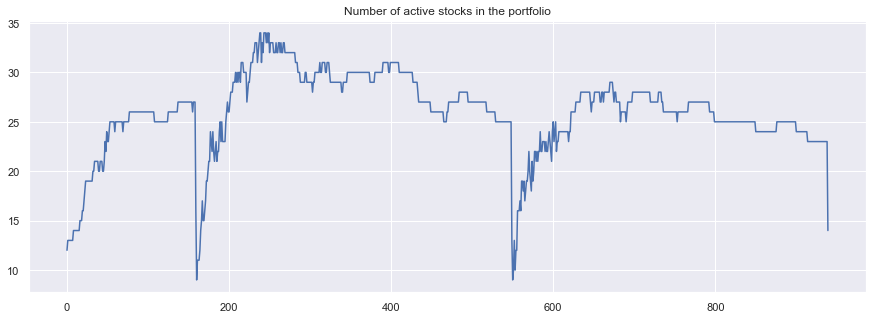

In [22]:
plt.figure(figsize=(15,5))
plt.title('Number of active stocks in the portfolio')
sns.lineplot([i for i in range(dfs.shape[0])], dfs[posCols].abs().sum(axis=1).values)

Above shows the number of active stocks in the portfolio.  We have atleast 9 stocks in our portfolio at any time and most of the time we are active in 30-40 stocks.

<AxesSubplot:title={'center':'long/short exposure'}>

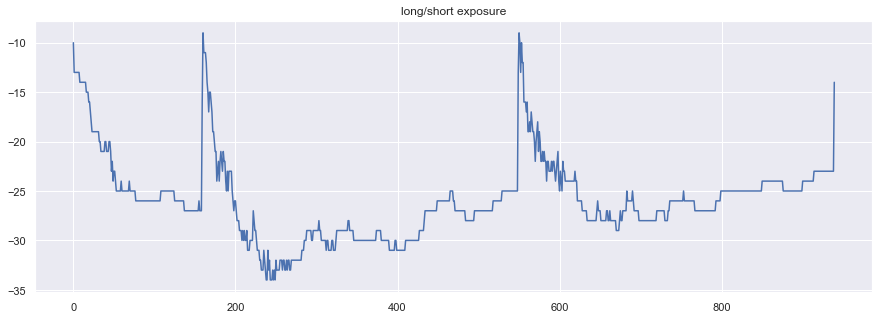

In [23]:
plt.figure(figsize=(15,5))
plt.title('long/short exposure')
sns.lineplot([i for i in range(dfs.shape[0])], dfs[posCols].sum(axis=1))

It is interesting to see that through the 3 day period our models are signaling mainly short portfolio

<AxesSubplot:title={'center':'Returns'}, ylabel='pnl'>

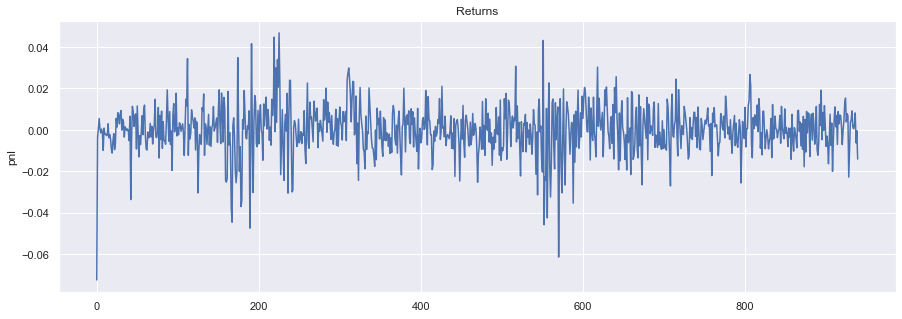

In [24]:
dfs['pnl'] = dfs[pnlCols].sum(axis=1)
plt.figure(figsize=(15,5))
plt.title('Returns')
sns.lineplot([i for i in range(dfs.shape[0])], dfs.pnl)

<AxesSubplot:title={'center':'Cumulative portfolio PnL'}, ylabel='pnl'>

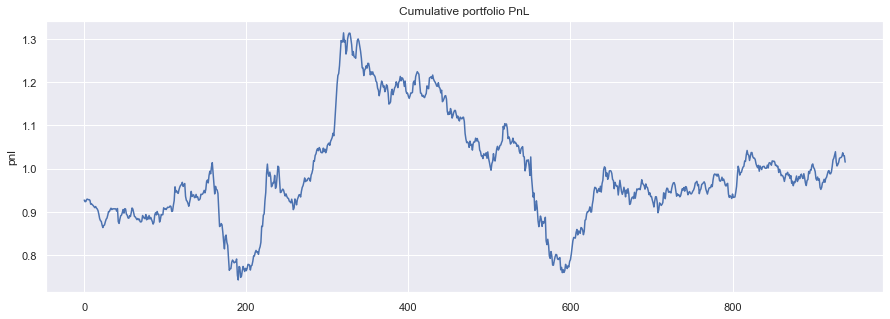

In [25]:
dfs['pnl'] = dfs[pnlCols].sum(axis=1)
plt.figure(figsize=(15,5))
plt.title('Cumulative portfolio PnL')
sns.lineplot([i for i in range(dfs.shape[0])], (dfs.pnl+1).cumprod())

In [27]:
(dfs.pnl+1).cumprod()

date  time
61    231     0.927415
      232     0.923713
      233     0.924108
      234     0.929144
      235     0.929555
                ...   
63    386     1.028307
      387     1.036699
      388     1.030116
      389     1.029701
      390     1.015114
Name: pnl, Length: 940, dtype: float64

The cumulative PnL over ~3 days is 1.015, which is realistic.  The peak of nearly 30% seems suspicious.  However, since the data given is synthetic data, I checked and saw that some stocks have +-4% return over a single minute.  This is quite unrealistic but it explains the peak in PnL.  If I hade more time, I would definetly try to dig deeper to get a better understanding of the PnL behaviour.

# 5. Future Work

Please note due to the time constraint, it was not possible to have sophisticaed approaches to every single component within the trading system. The work here shows a generic overview, and ofcourse each component is a open research topic, therefore can be improved significantly.

There are a few things on top of my head that I can think of which I would look into:

1. Lack of data is usually a problem in finance.  I have previously used autoencoders, extract intermidiary layer outputs and use as synthetic data for model training/validation.  This helps use to avoid p-hacking and gives us alot more data for experimentation.
2. During testing period, adjust models with the trailing error residuals to see if that is a better alternative to using static models. 
3. Ofcourse, better features.  Try to combine with macro, alternative data. We can also do vol/return clusters across the 50 stocks as features. Try forecasted vols, recurrent plots, ARIMA-GARCH predictions, clustering on dynamic time warping similarities between stocks.
4. Different ways of selecting features, e.g. using mutual information. 
5. More sophisticated portfolio construction technique.
6. Bet sizing using prediction probabilities.
7. A sophisticated risk management approach.
8. Sample weighting during training.
9. To note, we use lightgbm for several reasons in this task, mainly for speed + can handle no standarized data.  Would be interesting to test other approaches (classifical approaches).
10. Metalabelling. So far we always long/short.  We also need second models (meta models) which allows us to select where we enter the trade or not.
11. Better handling of missing values and outliers
12. Given additional domain knowledge, one could create features based on hypothesis testing rather than data mining.
13. Tweaking of entry/exit, at the moment it uses static probabilities, 0.75/-0.75 for long/short entry, exit at 0.